In [12]:
from datasets import load_dataset
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [5]:
ds = load_dataset(
    "c01dsnap/CIC-IDS2017",
    split="train",
    streaming=True
)

rows = []
for i, row in enumerate(ds):
    if i >= 30000:
        break
    rows.append(row)

df = pd.DataFrame(rows)

df.columns = df.columns.str.strip()
df["Label"] = df["Label"].str.strip()
df["target"] = df["Label"].apply(lambda x: 0 if x == "BENIGN" else 1)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

df.drop(columns=["Flow Bytes/s", "Flow Packets/s", "Label"], inplace=True, errors="ignore")

X = df.drop(columns=["target"])
y = df["target"]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
log_reg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)

print('Logistic Regression')
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4020
           1       1.00      1.00      1.00      1978

    accuracy                           1.00      5998
   macro avg       1.00      1.00      1.00      5998
weighted avg       1.00      1.00      1.00      5998

[[4012    8]
 [   1 1977]]


c:\Users\vitor\Documents\GitHub\cyber-ml-cicids2017\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


In [10]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print('Random Forest')
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test,y_pred_rf))


Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4020
           1       1.00      1.00      1.00      1978

    accuracy                           1.00      5998
   macro avg       1.00      1.00      1.00      5998
weighted avg       1.00      1.00      1.00      5998

[[4020    0]
 [   1 1977]]


## Conclusão

Os modelos apresentaram desempenho elevado na detecção de intrusão, com destaque para o Random Forest, que reduziu falsos positivos em relação à Logistic Regression.

Apesar dos resultados expressivos, o dataset CICIDS2017 é conhecido por possuir features altamente discriminativas, o que pode inflar as métricas. Trabalhos futuros incluem validação temporal e testes com subsets adicionais do dataset.


In [11]:
imporances = rf.feature_importances_

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': imporances
}).sort_values(by='importance', ascending=False)

feature_importance.head(10)

,feature,importance
13,Bwd Packet Length Std,0.092470
40,Packet Length Variance,0.073707
12,Bwd Packet Length Mean,0.063062
10,Bwd Packet Length Max,0.062337
39,Packet Length Std,0.055534
61,Subflow Fwd Bytes,0.051369
37,Max Packet Length,0.048009
6,Fwd Packet Length Max,0.044097
52,Avg Bwd Segment Size,0.039014
66,act_data_pkt_fwd,0.036109


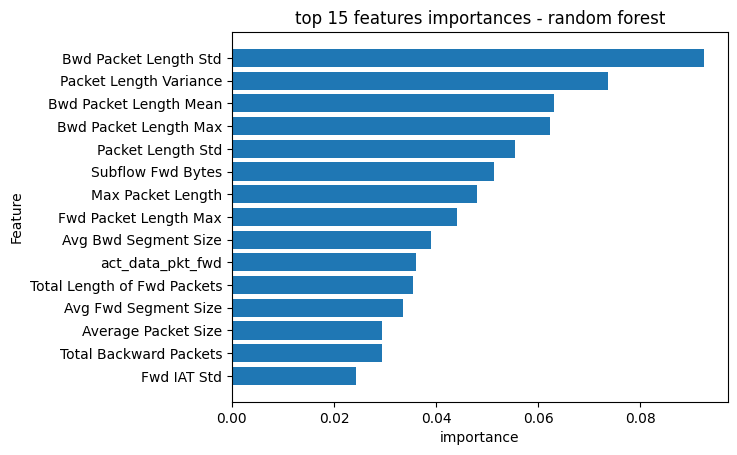

In [13]:
top_n = 15
top_features = feature_importance.head(top_n)

plt.figure()
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('importance')
plt.ylabel('Feature')
plt.title('top 15 features importances - random forest')
plt.gca().invert_yaxis()
plt.show()

## Feature Importance

A análise de importância das features revelou que variáveis relacionadas a
volume, duração e tamanho dos pacotes foram as mais relevantes para a
classificação do tráfego de rede.

Esse comportamento é consistente com o domínio do problema, uma vez que
ataques de rede tendem a apresentar padrões distintos de fluxo em relação
ao tráfego benigno.


A alta relevância de features de volume e tempo também pode indicar que o modelo aprende padrões específicos do dataset, reforçando a necessidade de validação em outros cenários

## Interpretação das Features Mais Importantes

A análise de importância das features mostrou que métricas relacionadas à
variabilidade do tamanho dos pacotes, especialmente no tráfego de retorno
(backward), foram as mais relevantes para a classificação.

Esses resultados são consistentes com o domínio do problema, uma vez que
ataques de rede tendem a gerar padrões irregulares e alta variância no
tamanho dos pacotes, diferindo do tráfego benigno mais estável.
